In [1]:
import pandas as pd
import h5py
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import joblib

In [19]:
HDF_NAME = 'monthly_combined_data.hdf'
with pd.HDFStore(HDF_NAME) as store:
    monthly_keys = [key[1:] for key in store.keys()]
    
SAVE_MODELS = False
X_COLUMNS = ['year', 'month', 'monthly_water_mean', 'monthly_water_total',
       'monthly_water_min', 'monthly_water_max', 'min_water_day',
       'max_water_day', 'mean_max_temp', 'mean_min_temp', 'mean_temp',
       'month_min_temp', 'month_max_temp', 'rain', 'total_snow', 'precip',
       'remaining_snow']
Y_COLUMN = 'monthly_water_mean'

In [26]:
def plot_errors(model, X_valid, y_valid, output_filename):
    plt.hist(y_valid - model.predict(X_valid), bins=100)
    plt.savefig('models/errors_{}.png'.format(output_filename))
    plt.close()

def plot_model(df, model, output_filename, filter_month=None):
    if filter_month:
        df = df[df['month'] == filter_month]
    # real values in blue, predicted values in red
    plt.plot(df[Y_COLUMN], 'b.', alpha=0.5)
    plt.scatter(df.index, model.predict(df[X_COLUMNS]), s=1, alpha=0.5, c='r')
    plt.show()
    plt.savefig('models/predict_{}.png'.format(output_filename))
    plt.close()
    
def plot_df_vals(df):
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(df))
    scaled_df.columns = df.columns
    scaled_df.index = df.index
    plt.plot(scaled_df.index, scaled_df['water_level'], c= 'b')
    plt.plot(scaled_df.index, scaled_df['precip'], c= 'r')
    plt.plot(scaled_df.index, scaled_df['rain'], c= 'yellow')
    plt.plot(scaled_df.index, scaled_df['mean_temp'], c='g')
    plt.plot(scaled_df.index, scaled_df['snow_precip'], c='aqua')
    plt.plot(scaled_df.index, scaled_df['snow_on_grnd'], c='magenta')
    
def model_scores(model, X_train, X_valid, y_train, y_valid):
    return {'train_score': model.score(X_train, y_train), 'valid_score': model.score(X_valid, y_valid)}

def train_and_generate_model(X_train, y_train, C, n_components, scaler):
    imputer = SimpleImputer()
    model = make_pipeline(
        imputer,
        scaler,
        PCA(n_components=n_components), # assume we have some kind of time, precip and temp dimensionality
        SVR(C=C, gamma='scale')
    )
    model.fit(X_train, y_train)
    return model

def prepare_df(df):
    X = df[X_COLUMNS]
    y = df[Y_COLUMN].values
    return (X, y)

In [17]:
def create_models(key,df=None, filter_month=None, show_plot=False, n_components=5, C=100, scaler=MinMaxScaler()):
    if df is None:
        df = pd.read_hdf(HDF_NAME, key=key).sort_index().dropna()
    X, y = prepare_df(df)
    
    if len(df) == 0:
        return None, None
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)

    model = train_and_generate_model(X_train, y_train, C=C, n_components=n_components, scaler=scaler)
    
    if show_plot:
        plot_model(df, model, key, filter_month)
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
        
    return model, model_scores(model, X_train, X_valid, y_train, y_valid)

In [6]:
def PCA_test(key):
    df = pd.read_hdf(HDF_NAME, key=key).sort_index().dropna()
    for i in range(2,8):
        print(key, i, create_models(key, df=df, n_components=i)[1])
    print()

In [7]:
def SVR_test(key):
    df = pd.read_hdf(HDF_NAME, key=key).sort_index().dropna()
    for i in range(-3,3):
        print(key, i, create_models(key, df=df, C=10**i)[1])
    print()

In [8]:
def Scaler_test(key):

    df = pd.read_hdf(HDF_NAME, key=key).sort_index().dropna()
    print(key, 'standard', create_models(key, df=df, scaler=StandardScaler())[1])
    print(key, 'minmax', create_models(key, df=df, scaler=MinMaxScaler())[1])
    print(key, 'robust', create_models(key, df=df, scaler=RobustScaler())[1])
    print()

In [28]:
# test best components. 5 looks pretty good
for key in monthly_keys:
    PCA_test(key)

hydro_07ED002 2 {'train_score': 0.9723202892891953, 'valid_score': 0.9627694497700288}
hydro_07ED002 3 {'train_score': 0.9740943504554069, 'valid_score': 0.92298998384914}
hydro_07ED002 4 {'train_score': 0.9907221680604088, 'valid_score': 0.9811878442940617}
hydro_07ED002 5 {'train_score': 0.9988231442143825, 'valid_score': 0.9817961059371323}
hydro_07ED002 6 {'train_score': 0.9993306984721462, 'valid_score': 0.9902021863900433}
hydro_07ED002 7 {'train_score': 0.9995711355161794, 'valid_score': 0.985826437149027}

hydro_08EB003 2 {'train_score': 0.9949301784165752, 'valid_score': 0.5882066224910458}
hydro_08EB003 3 {'train_score': 0.9947741612975637, 'valid_score': 0.8457787829266997}
hydro_08EB003 4 {'train_score': 0.9936538813510066, 'valid_score': 0.7290906223185218}
hydro_08EB003 5 {'train_score': 0.995556936363689, 'valid_score': 0.4657675169766218}
hydro_08EB003 6 {'train_score': 0.9947129455395799, 'valid_score': 0.39174100350820695}
hydro_08EB003 7 {'train_score': 0.99294506814

hydro_08NE103 4 {'train_score': 0.990029384956136, 'valid_score': 0.9809613368343537}
hydro_08NE103 5 {'train_score': 0.9968803014918448, 'valid_score': 0.9763612270127239}
hydro_08NE103 6 {'train_score': 0.998555473466006, 'valid_score': 0.9742020214544138}
hydro_08NE103 7 {'train_score': 0.9997124809601493, 'valid_score': 0.9852811765637606}

hydro_08NE104 2 {'train_score': 0.872046272877322, 'valid_score': 0.8772405783540111}
hydro_08NE104 3 {'train_score': 0.9591019542410506, 'valid_score': 0.9267428962638338}
hydro_08NE104 4 {'train_score': 0.972380325354876, 'valid_score': 0.9236583657576357}
hydro_08NE104 5 {'train_score': 0.9964724582621312, 'valid_score': 0.9851890268347556}
hydro_08NE104 6 {'train_score': 0.9971712698682191, 'valid_score': 0.9855469970469026}
hydro_08NE104 7 {'train_score': 0.9995835291261908, 'valid_score': 0.9967067993465276}

hydro_08NE126 2 None
hydro_08NE126 3 None
hydro_08NE126 4 None
hydro_08NE126 5 None
hydro_08NE126 6 None
hydro_08NE126 7 None

hydro

In [ ]:
# test best C value. 10e2 looks good, in terms of time/accuraccy tradeoff
for key in monthly_keys:
    SVR_test(key)

In [ ]:
# test best scaler. minmax looks the best
for key in monthly_keys:
    Scaler_test(key)

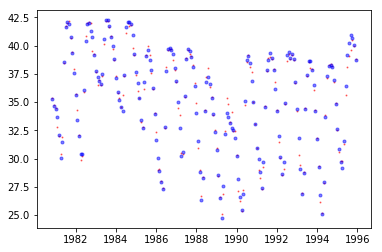

hydro_07ED002 {'train_score': 0.9952114564788441, 'valid_score': 0.9731613842440319}


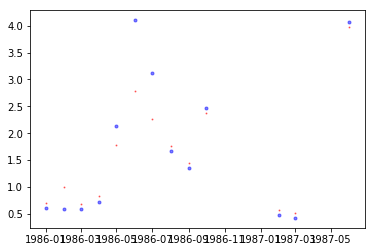

hydro_08EB003 {'train_score': 0.9925193796452595, 'valid_score': 0.586778076721196}


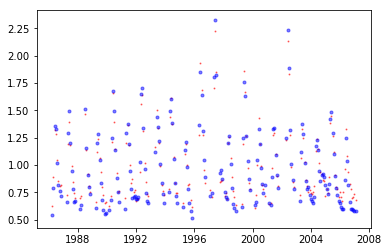

hydro_08EC001 {'train_score': 0.971500431545385, 'valid_score': 0.9155115070558061}
hydro_08GA030 None
hydro_08GA077 None
hydro_08GA079 None
hydro_08GB013 None


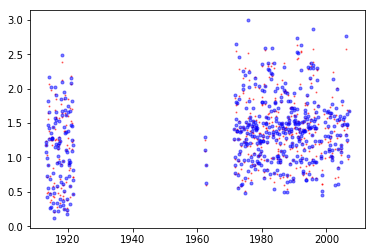

hydro_08HA009 {'train_score': 0.984060169612832, 'valid_score': 0.9640471389215434}


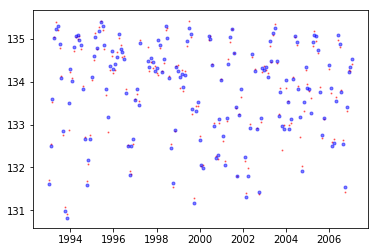

hydro_08HB082 {'train_score': 0.9944647009779781, 'valid_score': 0.9217158436839459}


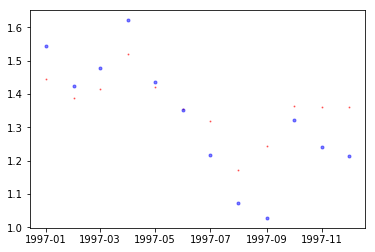

hydro_08HC006 {'train_score': 0.7892079623298972, 'valid_score': -2.0151806515148865}


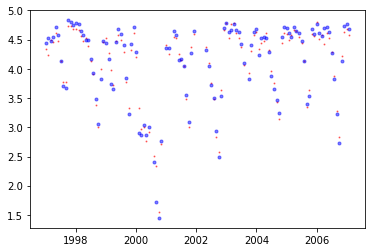

hydro_08HD025 {'train_score': 0.9858715124205412, 'valid_score': 0.9418322500987353}


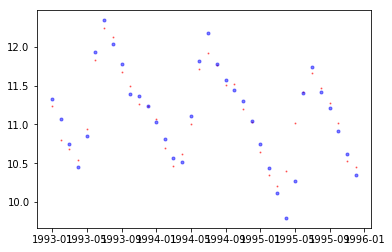

hydro_08JA023 {'train_score': 0.9761292156065832, 'valid_score': 0.7061637042150006}


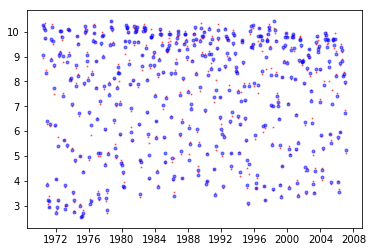

hydro_08LC041 {'train_score': 0.9974688829780722, 'valid_score': 0.9918693224369962}
hydro_08MH141 None


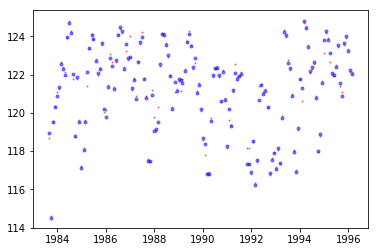

hydro_08MH148 {'train_score': 0.997202763299723, 'valid_score': 0.93847131591685}


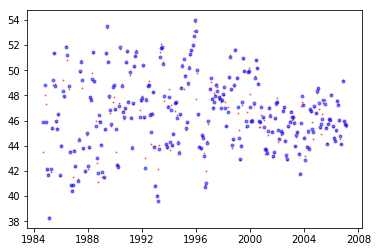

hydro_08MH149 {'train_score': 0.9957860015860694, 'valid_score': 0.8783128684271904}
hydro_08MH167 None


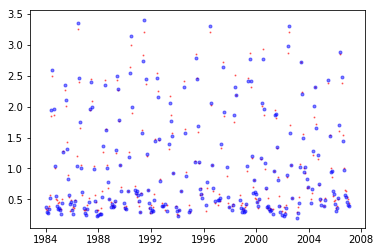

hydro_08NA002 {'train_score': 0.9925305424229413, 'valid_score': 0.9884257553494529}


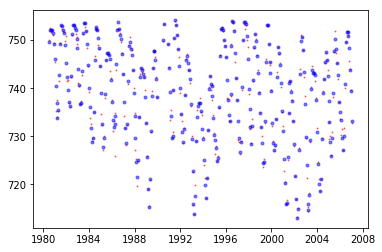

hydro_08NB017 {'train_score': 0.9905410896378103, 'valid_score': 0.972090042035629}


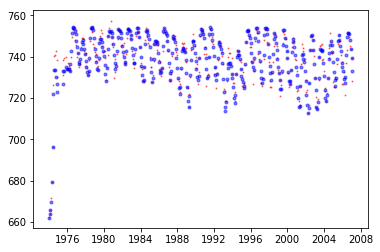

hydro_08ND017 {'train_score': 0.9539687401058744, 'valid_score': 0.8840248283418641}


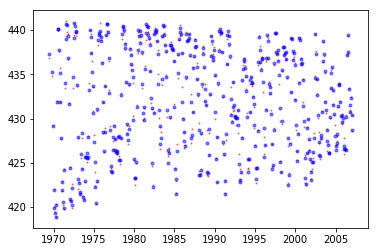

hydro_08NE102 {'train_score': 0.9969818649469203, 'valid_score': 0.9908178141618206}


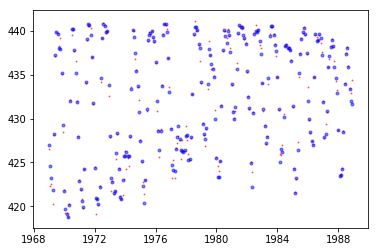

hydro_08NE103 {'train_score': 0.99660384388948, 'valid_score': 0.9733780328664313}


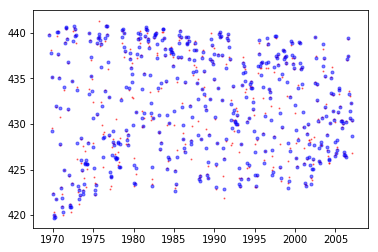

hydro_08NE104 {'train_score': 0.986420487086328, 'valid_score': 0.9380839944312094}
hydro_08NE126 None


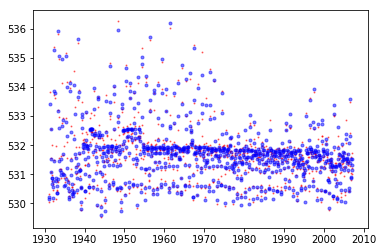

hydro_08NH064 {'train_score': 0.9689330201351383, 'valid_score': 0.9054832988605754}


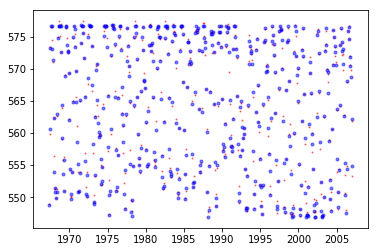

hydro_08NH127 {'train_score': 0.9971501437230945, 'valid_score': 0.990310379063105}
hydro_08NM202 None
hydro_08NM212 None


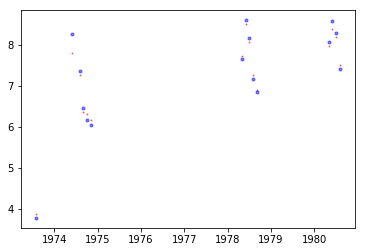

hydro_08NM213 {'train_score': 0.9941531952220886, 'valid_score': 0.9300788050297488}
hydro_08NM234 None


In [31]:
# monthly groupby, accuracy suffers from lack of datapoints
for key in monthly_keys:
    df = pd.read_hdf(HDF_NAME, key=key).sort_index()
    df.index = df.apply(lambda x: dt.date(year=int(x['year']), month=int(x['month']), day=1), axis=1)
    print(key, create_models(key, df=df, show_plot=True)[1])